# Powerplant Optimization with Differential Evolution

All information is taken from "Differential Evolution: A Survey of the State-of-the-Art"by Swagatam Das, Member, IEEE, and Ponnuthurai Nagaratnam Suganthan, Senior Member, IEEE.

In [5]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

We aim to optimize two parameters: the scaling factor (mutation) and the crossover probability. Moreover, we consider different instantiations.

Note that we consider the scaling factor $\in [0.4, 1]$. The reason for that is that finding an optimal solutions is difficult for a scaling factor greater than $1$ since we have "big steps". For a scaling factor smaller than $0.4$ these steps are considerably small and therefore increase the run time drastically .

## 1. Initialization 

Randomly initiated population of real-valued parameter vectors. Each vector, called chromosome, forms a candidate solution to the multidimensional optimization problem.

In [6]:
def initialize(population_size_NP,e1,e2,e3,d1,d2,d3,p1,p2,p3):
    # randomly initialize a population of NP individuals within the domain
    population = []
    random_chromosome = []
    for i in range(population_size_NP):
        random_chromosome = []
        # initialize energy produced:
        random_chromosome.append(random.uniform(0,e1))
        random_chromosome.append(random.uniform(0,e2))
        random_chromosome.append(random.uniform(0,e3))
        
        # initialize demands
        random_chromosome.append(random.uniform(0,d1))
        random_chromosome.append(random.uniform(0,d2))
        random_chromosome.append(random.uniform(0,d3))
        
        # initialize prices
        random_chromosome.append(random.uniform(0,p1))
        random_chromosome.append(random.uniform(0,p2))
        random_chromosome.append(random.uniform(0,p3))
        
        population.append(random_chromosome)
    
    return population

## 2. Mutation

In the mutation step we created a so called donor vector from randomly choosen vectors of our population. Due to the fact, that this "mutation" can create a vector, that is outside the boundaries of ou problem, we alwys check the feasibility of our solution. Therefore it is guarenteed, that the mutation step always generates a feasible solution according to our problem.

In [7]:
# This function checks, wether the created donor_vector is feasible or not. If it is not feasible, the corresponding value,
# which exceeds the boundary, is changed to the boundary itself (as it is proposed in the paper).
def make_vector_feasible(donor_vector,e1,e2,e3,d1,d2,d3,p1,p2,p3):
    feasible = True
    if (donor_vector[0] < 0):
        donor_vector[0] = 0
    if (donor_vector[0] > e1):
        donor_vector[0] = e1
    if (donor_vector[1] < 0):
        donor_vector[1] = 0
    if (donor_vector[1] > e2):
        donor_vector[1] = e2
    if (donor_vector[2] < 0):
        donor_vector[2] = 0
    if (donor_vector[2] > e3):
        donor_vector[2] = e3
    if (donor_vector[3] < 0):
        donor_vector[3] = 0
    if (donor_vector[3] > d1):
        donor_vector[3] = d1
    if (donor_vector[4] < 0):
        donor_vector[4] = 0
    if (donor_vector[4] > d2):
        donor_vector[4] = d2
    if (donor_vector[5] < 0):
        donor_vector[5] = 0
    if (donor_vector[5] > d3):
        donor_vector[5] = d3
    if (donor_vector[6] < 0):
        donor_vector[6] = 0
    if (donor_vector[6] > p1):
        donor_vector[6] = p1
    if (donor_vector[7] < 0):
        donor_vector[7] = 0
    if (donor_vector[7] > p2):
        donor_vector[7] = p2
    if (donor_vector[8] < 0):
        donor_vector[8] = 0
    if (donor_vector[8] > p3):
        donor_vector[8] = p3
        
    return donor_vector

In [8]:
def mutate(target_vector_X,scale_factor_F,population,e1,e2,e3,d1,d2,d3,p1,p2,p3):
    population_size = len(population)
    param_vectors = []
    vectors_used = 0
    while vectors_used < 3:
        rand = random.randint(0, population_size-1)
        new_vector = population[rand]

        # check if new_vector is not the target_vector_X and not already chosen for param_vectors
        if not np.array_equiv(new_vector,target_vector_X):
            if vectors_used == 0:
                param_vectors.append(new_vector)
                vectors_used += 1
            else:
                for i in range(vectors_used):
                    if not np.array_equiv(new_vector, param_vectors[i]):
                            param_vectors.append(new_vector)
                            vectors_used += 1
                            break

    donor_vector_V = param_vectors[0] + scale_factor_F*(param_vectors[1]-param_vectors[2])
    donor_vector_V = make_vector_feasible(donor_vector_V,e1,e2,e3,d1,d2,d3,p1,p2,p3)
    
    return donor_vector_V

## 3. Crossover / Recombination

In the crossover step, we switch different digits between the target and the donor vector with a certain crossover rate to form a new trial vector. For our implementation, we have choosen the binomial (or uniform) crossover, which always chosses on digit at a time.

In [9]:
def crossover(target_vector_X,donor_vector_V,cross_over_rate_Cr):
    trial_vector_U = np.copy(target_vector_X)
    D = len(target_vector_X)
    for j in range(D):
        j_rand = random.randint(1,D)
        if (random.random() <= cross_over_rate_Cr) or j == j_rand :
            trial_vector_U[j] = donor_vector_V[j]
        else:
            trial_vector_U[j] = target_vector_X[j]
    return trial_vector_U

## 4. Selection

In the selection part, we choose a new target vector based on our observation function. If the generated trial of the steps before corresponds to a better value of observation funtion, we choose this vector as a new target vector. Otherwise we choose our target vector again.

Our objective function depends on the demand and on the cost function. The demand function returns our current demand depending on the price, the maximum price and the maximum demand and the cost function returns our current cost depending on our current produced energy, on the energy per plant, on the cost per plant and on the maximum number of plants.

In [10]:
def demand(price, maxPrice, maxDemand):
    if(price > maxPrice):
        return 0
    
    if(price <= 0):
        return maxDemand
    
    demand = maxDemand - price**2 * maxDemand / maxPrice**2
    
    return demand

In [11]:
def cost(x, kwhPerPlant, costPerPlant, maxPlants):
    if(x <= 0):
        return 0
    
    if(x > kwhPerPlant * maxPlants):
        return float("Inf")
    
    plantsNeeded = math.ceil(x / kwhPerPlant)
    
    return plantsNeeded * costPerPlant

In [12]:
def objective(tested_vector,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3):
    kwhPerPlant1 = e1 // 100
    kwhPerPlant2 = e2 // 50
    kwhPerPlant3 = e3 // 3
    
    # each e already provides the sum of energy produced per plant type
    total_energy_produced = tested_vector[0] + tested_vector[1] + tested_vector[2]
    
    total_energy_planned =  tested_vector[3] + tested_vector[4] + tested_vector[5]
    
    purchasing_cost = max((total_energy_planned-total_energy_produced),0)*cost_price
    
    production_cost = cost(tested_vector[0], kwhPerPlant1, 10000, 100) + cost(tested_vector[1], kwhPerPlant2, 80000, 50) + cost(tested_vector[2], kwhPerPlant3, 400000, 3)
    
    total_cost = purchasing_cost + production_cost
    
    revenue = min(demand(tested_vector[6], p1, d1), tested_vector[3])*tested_vector[6] + min(demand(tested_vector[7], p2, d2), tested_vector[4])*tested_vector[7] + min(demand(tested_vector[8], p3, d3), tested_vector[5])*tested_vector[8]
    
    #profit equals fitness
    profit = revenue - total_cost
    
    return profit

In [13]:
def select(target_vector_X,trial_vector_U,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3):
    # Evaluate the trial vector and choose new target vector with better value

    if objective(target_vector_X,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3) > objective(trial_vector_U,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3):
        new_target_vector = target_vector_X
    else:
        new_target_vector = trial_vector_U

    return new_target_vector

## 5. Action

This part combines the different steps into a whole algorithm. First the parameter settings, then the initialization step and then a while loop with the mutation, crossover and selection step until the convergence criterium is met, are programmed.

In [14]:
# this function returns the best solution of our population based on our objective function
def get_best(new_population,population_size_NP,e1,e2,e3,d1,d2,d3,p1,p2,p3):
    #choose the best one of the final population
    best_chromosome = new_population[0]
    for i in range(population_size_NP):
        if objective(new_population[i],cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3) > objective(best_chromosome,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3):
            best_chromosome = new_population[i]

    return best_chromosome

In [15]:
# set factors:
scale_factor_F = 1
cross_over_rate_Cr = 0.2
population_size_NP = 30
cost_price = 0.6

# total energy values (for all plants)
e1 = 5000000
e2 = 30000000
e3 = 12000000

# market prices
p1 = 0.45
p2 = 0.25
p3 = 0.2

# market demands
d1 = 2000000
d2 = 30000000
d3 = 20000000

# Initialization:
generation_number_G = 0
new_population = initialize(population_size_NP,e1,e2,e3,d1,d2,d3,p1,p2,p3)
best_solution_list = []

converged = False
while not converged:
    population = np.copy(new_population)
    for i in range(population_size_NP):
        target_vector_X = population[i]
        
        # Mutation:
        donor_vector_V = mutate(target_vector_X,scale_factor_F,population,e1,e2,e3,d1,d2,d3,p1,p2,p3)
        
        # Crossover:
        trial_vector_U = crossover(target_vector_X,donor_vector_V,cross_over_rate_Cr)
        
        # Selection:
        new_population[i] = select(target_vector_X,trial_vector_U,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3)
    
    generation_number_G += 1
    converged = (generation_number_G == 1000)
    #choose the best one of the final population
    best_chromosome = get_best(new_population,population_size_NP,e1,e2,e3,d1,d2,d3,p1,p2,p3)
    best_solution_list.append(objective(best_chromosome,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3))
    
print("done!")
print("best Chromosome:")
print(best_chromosome)
print(objective(best_chromosome,cost_price,e1,e2,e3,d1,d2,d3,p1,p2,p3))

done!
best Chromosome:
[  0.00000000e+00   7.16456013e+06   1.20000000e+07   1.06364052e+06
   1.13929255e+07   6.68918185e+06   3.08184065e-01   1.96253078e-01
   1.62435401e-01]
1489733.12939


## 6. Plot

In [16]:
def simple_plot(best_profit_per_run,minimum_solution,best_solution,scale_factor_F_plot,cross_over_rate_Cr_plot,population_size_NP_plot,cost_price_plot):
    fig, ax = plt.subplots(figsize=plt.figaspect(0.2))
    ax.plot(best_profit_per_run, ':r', label=f"F: {scale_factor_F_plot}\nCr: {cross_over_rate_Cr_plot}\npopulation size: {population_size_NP_plot}\ncost price: {cost_price_plot}")
    ax.set(ylim=[minimum_solution,best_solution],ylabel='Profit', xlabel='Iteration', title='DE on Power Plant Optimization')
    ax.legend()
    plt.show()
    fig.savefig(f"plots/F{scale_factor_F_plot}_Cr{cross_over_rate_Cr_plot}_PopSize{population_size_NP_plot}_CostPrice{cost_price_plot}.png")

Best solution in this run:  1489733.12939


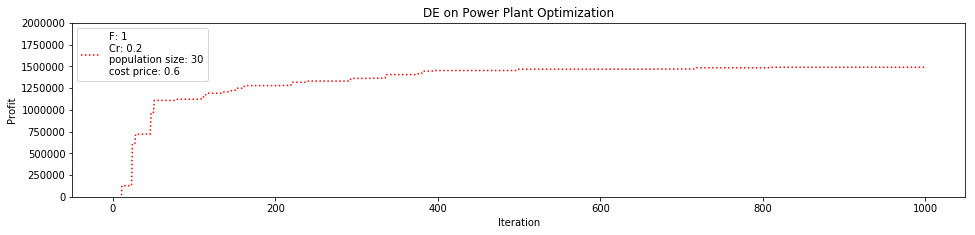

In [17]:
best_profit_per_run = best_solution_list
best_solution = max(best_solution_list)
scale_factor_F_plot = scale_factor_F
cross_over_rate_Cr_plot = cross_over_rate_Cr
population_size_NP_plot = population_size_NP
cost_price_plot = cost_price

print("Best solution in this run: ",best_solution)
simple_plot(best_profit_per_run,0,2000000,scale_factor_F_plot,cross_over_rate_Cr_plot,population_size_NP_plot,cost_price_plot)